
Hyper-parameters of Approximate Nearest Neighbors

This example demonstrates the behaviour of the
accuracy of the nearest neighbor queries of Locality Sensitive Hashing
Forest as the number of candidates and the number of estimators (trees)
vary.

In the first plot, accuracy is measured with the number of candidates. Here,
the term "number of candidates" refers to maximum bound for the number of
distinct points retrieved from each tree to calculate the distances. Nearest
neighbors are selected from this pool of candidates. Number of estimators is
maintained at three fixed levels (1, 5, 10).

In the second plot, the number of candidates is fixed at 50. Number of trees
is varied and the accuracy is plotted against those values. To measure the
accuracy, the true nearest neighbors are required, therefore
:class:`sklearn.neighbors.NearestNeighbors` is used to compute the exact
neighbors.



/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


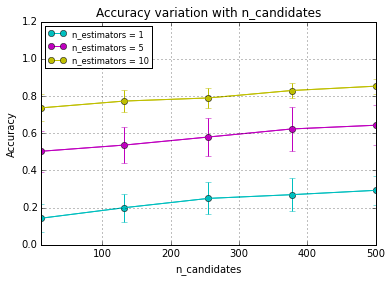

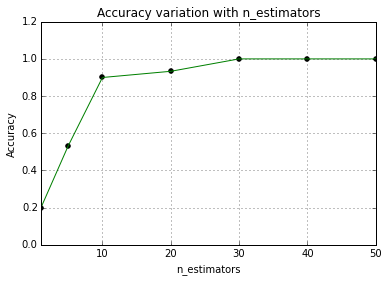

In [1]:
"""
=================================================
Hyper-parameters of Approximate Nearest Neighbors
=================================================

This example demonstrates the behaviour of the
accuracy of the nearest neighbor queries of Locality Sensitive Hashing
Forest as the number of candidates and the number of estimators (trees)
vary.

In the first plot, accuracy is measured with the number of candidates. Here,
the term "number of candidates" refers to maximum bound for the number of
distinct points retrieved from each tree to calculate the distances. Nearest
neighbors are selected from this pool of candidates. Number of estimators is
maintained at three fixed levels (1, 5, 10).

In the second plot, the number of candidates is fixed at 50. Number of trees
is varied and the accuracy is plotted against those values. To measure the
accuracy, the true nearest neighbors are required, therefore
:class:`sklearn.neighbors.NearestNeighbors` is used to compute the exact
neighbors.
"""
from __future__ import division
print(__doc__)

# Author: Maheshakya Wijewardena <maheshakya.10@cse.mrt.ac.lk>
#
# License: BSD 3 clause


###############################################################################
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
from sklearn.neighbors import LSHForest
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

%matplotlib inline

# Initialize size of the database, iterations and required neighbors.
n_samples = 10000
n_features = 100
n_queries = 30
rng = np.random.RandomState(42)

# Generate sample data
X, _ = make_blobs(n_samples=n_samples + n_queries,
                  n_features=n_features, centers=10,
                  random_state=0)
X_index = X[:n_samples]
X_query = X[n_samples:]
# Get exact neighbors
nbrs = NearestNeighbors(n_neighbors=1, algorithm='brute',
                        metric='cosine').fit(X_index)
neighbors_exact = nbrs.kneighbors(X_query, return_distance=False)

# Set `n_candidate` values
n_candidates_values = np.linspace(10, 500, 5).astype(np.int)
n_estimators_for_candidate_value = [1, 5, 10]
n_iter = 10
stds_accuracies = np.zeros((len(n_estimators_for_candidate_value),
                            n_candidates_values.shape[0]),
                           dtype=float)
accuracies_c = np.zeros((len(n_estimators_for_candidate_value),
                         n_candidates_values.shape[0]), dtype=float)

# LSH Forest is a stochastic index: perform several iteration to estimate
# expected accuracy and standard deviation displayed as error bars in
# the plots
for j, value in enumerate(n_estimators_for_candidate_value):
    for i, n_candidates in enumerate(n_candidates_values):
        accuracy_c = []
        for seed in range(n_iter):
            lshf = LSHForest(n_estimators=value,
                             n_candidates=n_candidates, n_neighbors=1,
                             random_state=seed)
            # Build the LSH Forest index
            lshf.fit(X_index)
            # Get neighbors
            neighbors_approx = lshf.kneighbors(X_query,
                                               return_distance=False)
            accuracy_c.append(np.sum(np.equal(neighbors_approx,
                                              neighbors_exact)) /
                              n_queries)

        stds_accuracies[j, i] = np.std(accuracy_c)
        accuracies_c[j, i] = np.mean(accuracy_c)

# Set `n_estimators` values
n_estimators_values = [1, 5, 10, 20, 30, 40, 50]
accuracies_trees = np.zeros(len(n_estimators_values), dtype=float)

# Calculate average accuracy for each value of `n_estimators`
for i, n_estimators in enumerate(n_estimators_values):
    lshf = LSHForest(n_estimators=n_estimators, n_neighbors=1)
    # Build the LSH Forest index
    lshf.fit(X_index)
    # Get neighbors
    neighbors_approx = lshf.kneighbors(X_query, return_distance=False)
    accuracies_trees[i] = np.sum(np.equal(neighbors_approx,
                                          neighbors_exact))/n_queries

###############################################################################
# Plot the accuracy variation with `n_candidates`
fig = plt.figure()
colors = ['c', 'm', 'y']
for i, n_estimators in enumerate(n_estimators_for_candidate_value):
    label = 'n_estimators = %d ' % n_estimators
    plt.plot(n_candidates_values, accuracies_c[i, :],
             'o-', c=colors[i], label=label)
    plt.errorbar(n_candidates_values, accuracies_c[i, :],
                 stds_accuracies[i, :], c=colors[i])

plt.legend(loc='upper left', fontsize='small')
plt.ylim([0, 1.2])
plt.xlim(min(n_candidates_values), max(n_candidates_values))
plt.ylabel("Accuracy")
plt.xlabel("n_candidates")
plt.grid(which='both')
plt.title("Accuracy variation with n_candidates")

fig.savefig('graph.png')

# Plot the accuracy variation with `n_estimators`
fig = plt.figure()
plt.scatter(n_estimators_values, accuracies_trees, c='k')
plt.plot(n_estimators_values, accuracies_trees, c='g')
plt.ylim([0, 1.2])
plt.xlim(min(n_estimators_values), max(n_estimators_values))
plt.ylabel("Accuracy")
plt.xlabel("n_estimators")
plt.grid(which='both')
plt.title("Accuracy variation with n_estimators")

plt.show()
fig.savefig('graph1.png')

